<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [18]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

Label is: 3
Image shape: torch.Size([3, 32, 32])


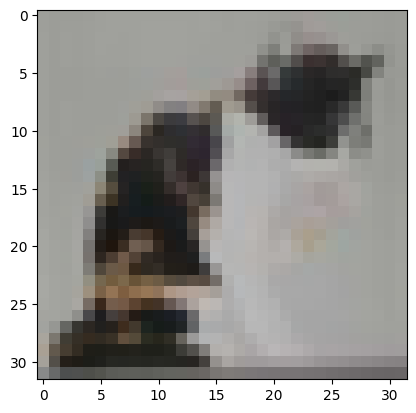

In [19]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [20]:
#Creating dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)


In [21]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

In [22]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))


In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_test, stds_test)])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [24]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))


# **II. Model implementation**